# Housing Model - Multiple Factors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random
import scipy as sp

In [2]:
def random_board(n, m, p, rho):
    """
    Initialize the grids with random affluence levels, house values, and religion.
    """
    # Initialize the affluence grid based on given probabilities
    affluence_grid = np.random.choice(
        [affluence_levels["rich"], affluence_levels["middle"], affluence_levels["poor"]],
        size=(n, m), p=p
    )
    
    # Initialize the house grid with zeros
    house_grid = np.random.uniform(0,1,(n,m))  # All house values start as uniform(0,1)
    
    # Initialize the religion grid with binary values (1 or 0) with uniform distribution
    religion_grid = np.random.choice([1, 0], size=(n, m), p=[0.5, 0.5])

    # Initialize the political opinion grid with values (0, 0.5, 1) so that it is correlated to affluence
    # Generate a noise matrix
    noise = np.random.rand(n, m)
    # Create the political opinion matrix with correlation to affluence
    continuous_political_grid = rho * affluence_grid + (1-rho) * noise
    
    # Define thresholds for mapping to discrete values to create approximately uniformly distributed opinions (can be adjusted)
    political_grid = np.zeros_like(continuous_political_grid)
    political_grid[continuous_political_grid < 0.33] = 0 # Left
    political_grid[(continuous_political_grid >= 0.33) & (continuous_political_grid < 0.66)] = 0.5 # Center
    political_grid[continuous_political_grid >= 0.66] = 1 # Right
    
    return affluence_grid, house_grid, religion_grid, political_grid

#### Checking correlation of political opinion and affluence

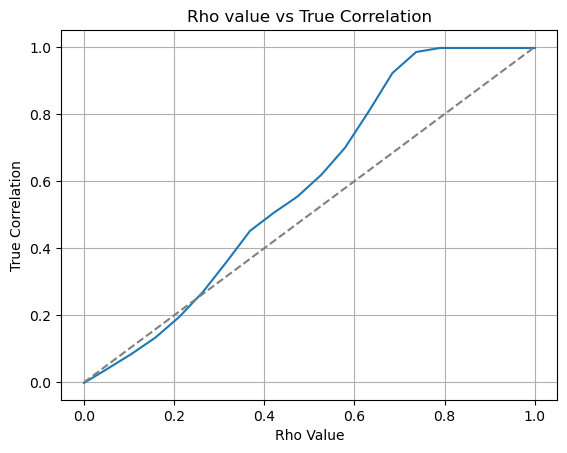

In [18]:
n, m = 50, 50  # Grid size

# Define affluence values for rich, middle, and poor
affluence_levels = {
    "rich": 1.0,
    "middle": 0.5,
    "poor": 0.1
}

# Probabilities of rich, middle and poor
p = [0.1, 0.6, 0.3]
rhos = np.linspace(0, 1, 20)
correlations = []
for rho in rhos:
    corr = 0
    for i in range(200):
        affluence_grid, house_grid, religion_grid, political_grid = random_board(n,m,p,rho)
        # Flatten matrices
        flat1 = affluence_grid.flatten()
        flat2 = political_grid.flatten()
        
        # Compute Pearson correlation
        corr += np.corrcoef(flat1, flat2)[0, 1]
    correlations.append(corr/200)

# Plotting
plt.plot(rhos, correlations)
plt.xlabel('Rho Value')
plt.ylabel('True Correlation')
plt.title('Rho value vs True Correlation')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.grid(True)
plt.show()

In [22]:
# Initialize variables
n_iterations = 200
averaged_distribution = {}

# Run 10 iterations to calculate the average distribution
for j in range(n_iterations):
    affluence_grid, house_grid, religion_grid, political_grid = random_board(n, m, p, rho=0.3)

    # Flatten the matrix to a 1D array
    flattened_grid = political_grid.flatten()

    # Find unique values and their counts
    unique_values, counts = np.unique(flattened_grid, return_counts=True)

    # Calculate the probabilities
    probabilities = counts / flattened_grid.size

    # Combine values and probabilities into a dictionary and accumulate
    for value, prob in zip(unique_values, probabilities):
        if value in averaged_distribution:
            averaged_distribution[value].append(prob)
        else:
            averaged_distribution[value] = [prob]

# Now calculate the average for each value
for value in averaged_distribution:
    averaged_distribution[value] = np.mean(averaged_distribution[value])

# Print the average distribution
print("Average Probability Distribution of Political Opinion:")
for value, prob in averaged_distribution.items():
    print(f"Value {value}: {prob:.2%}")

Average Probability Distribution of Political Opinion:
Value 0.0: 30.51%
Value 0.5: 47.12%
Value 1.0: 22.37%


In [5]:
def create_weighted_kernel(r):
    """
    Creates a weighted kernel with closer neighbors having higher weight.
    Weights are inversely proportional to the distance from the centre.
    
    Parameters:
    r (int): Radius of the kernel.
    
    Returns:
    numpy.ndarray: Weighted kernel.
    """
    size = 2 * r + 1
    center = r
    kernel = np.zeros((size, size), dtype=np.float64)
    
    # Compute weights using inverse square distance
    for i in range(size):
        for j in range(size):
            if i == center and j == center:
                # Set center weight to 0 to exclude self from neighborhood average
                kernel[r,r] = 0
            else:
                distance = np.sqrt( (i - center) ** 2 + (j - center) ** 2 )
                kernel[i, j] = 1 / distance
    
    # Normalize the kernel so that weights sum to 1
    kernel /= kernel.sum()
    return kernel

In [7]:
def calculate_neighborhood_average(grid, x, y, r, kernel):
    """
    Calculate the weighted average house value in the square neighborhood of radius r around (x, y),
    with closer neighbours having more weight according to inverse square distance.
    """
    n, m = grid.shape
    weighted_sum = 0
    total_weight = 0
    
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(n, x + r + 1), min(m, y + r + 1)
    
    # Iterate over the neighborhood within the radius
    k = 0
    for i in range(x_min, x_max):
        l = 0
        for j in range(y_min, y_max):
            # Weighted sum and total weight
            weighted_sum += grid[i, j] * kernel[k,l]
            total_weight += kernel[k,l]
            l += 1
        k += 1

    # Calculate the weighted average of the neighborhood
    weighted_average = weighted_sum / total_weight
    return weighted_average

In [9]:
def calculate_num_neighbours(house_grid, r):
    """Create a grid that counts the number of neighbours around that point in house_grid, in square nbhd radius r.
    Assumes house_grid has -1s for non-houses. Uses that rather than 0 to allow for houses that actually have 0 value."""
    # split into 1 for has house there and 0 for doesn't
    house_grid_binary = np.copy(house_grid)
    house_grid_binary = np.where(house_grid_binary == -1, 0, 1)

    # counts number of houses in nbhd including myself
    kernel = np.ones((2*r + 1, 2*r + 1))
    num_neighbours = sp.signal.convolve2d(house_grid_binary, kernel, mode='same', boundary="symm")

    return num_neighbours

In [11]:
def calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_, calc_num_neighbours = False):
    """Calculates new house values using a convolution.

    Args:
        house_grid (np.ndarray): House price grid V
        affluence_grid (np.ndarray): Affluence grid A
        r (int): Neighbourhood radius
        lambda_ (float): Modeling parameter
        calc_num_neighbours (bool, optional): Whether to calculate number of neighbours or to just use kernel size. When the 
        grid is full (as in the toy model), we can set this to false as there are always the same number of neighbours. Defaults to False.

    Returns:
        np.ndarray: The new house values
    """
    # Reset empty grid points (roads etc) to 0 to aid calculation
    house_grid_zeroed = np.copy(house_grid)
    house_grid_zeroed = np.where(house_grid_zeroed == -1, 0, house_grid_zeroed)

    kernel = np.ones((2*r + 1, 2*r + 1))

    if calc_num_neighbours:
        num_neighbours = calculate_num_neighbours(house_grid, r)
    else:
        num_neighbours = kernel.size

    # Updated house prices. idk if symmetric bdary conditions is the right thing to do
    nbhd_average = sp.signal.convolve2d(house_grid_zeroed, kernel, mode='same', boundary="symm") / num_neighbours
    V_tplus1 = affluence_grid + lambda_*nbhd_average
    V_tplus1 = np.where(house_grid == -1, -1, V_tplus1) # make sure to keep gaps from before

    return V_tplus1

In [13]:
def propose_swap(affluence_grid, house_grid, religion_grid, politics_grid, r, kernel):
    """
    Calculate delta and swap agents if delta > 0.
    """
    n, m = house_grid.shape
    # Choose two random houses
    x1, y1 = random.randint(0, n-1), random.randint(0, m-1)
    x2, y2 = random.randint(0, n-1), random.randint(0, m-1)

    A_x1, A_x2 = affluence_grid[x1, y1], affluence_grid[x2, y2]
    V_x1, V_x2 = house_grid[x1, y1] / np.max(house_grid), house_grid[x2, y2] / np.max(house_grid)
    delta_econ = (A_x1 - V_x1)**2 + (A_x2 - V_x2)**2 - (A_x1 - V_x2)**2 - (A_x2 - V_x1)**2

    R_x1, R_x2 = religion_grid[x1, y1], religion_grid[x2, y2]
    R_nbhd_x1, R_nbhd_x2 = calculate_neighborhood_average(religion_grid, x1, y1, r, kernel), calculate_neighborhood_average(religion_grid, x2, y2, r, kernel)
    delta_rel = (R_x1 - R_nbhd_x1)**2 + (R_x2 - R_nbhd_x2)**2 - (R_x1 - R_nbhd_x2)**2 - (R_x2 - R_nbhd_x1)**2
    
    P_x1, P_x2 = politics_grid[x1, y1], politics_grid[x2, y2]
    P_nbhd_x1, P_nbhd_x2 = calculate_neighborhood_average(politics_grid, x1, y1, r, kernel), calculate_neighborhood_average(politics_grid, x2, y2, r, kernel)
    delta_pol = (P_x1 - P_nbhd_x1)**2 + (P_x2 - P_nbhd_x2)**2 - (P_x1 - P_nbhd_x2)**2 - (P_x2 - P_nbhd_x1)**2 

    if delta_econ > 0 and 0.5 * delta_rel + 0.5 * delta_pol > 0:
        # Swap the two agents on all grids
        affluence_grid[x1, y1], affluence_grid[x2, y2] = A_x2, A_x1
        religion_grid[x1, y1], religion_grid[x2, y2] = R_x2, R_x1
        politics_grid[x1, y1], politics_grid[x2, y2] = P_x2, P_x1
        return 1
    else:
        return 0

#### Simulation

In [55]:
# Parameters
lambda_ = 0.99  # lambda parameter for updating house values
n, m = 50, 50  # Grid size

# Define affluence values for rich, middle, and poor
affluence_levels = {
    "rich": 1.0,
    "middle": 0.5,
    "poor": 0.1
}

# Probabilities of rich, middle and poor
p = [0.1, 0.6, 0.3]

# Radius of square neighbourhood
r = 2

rho = 0.3

kernel = create_weighted_kernel(r)

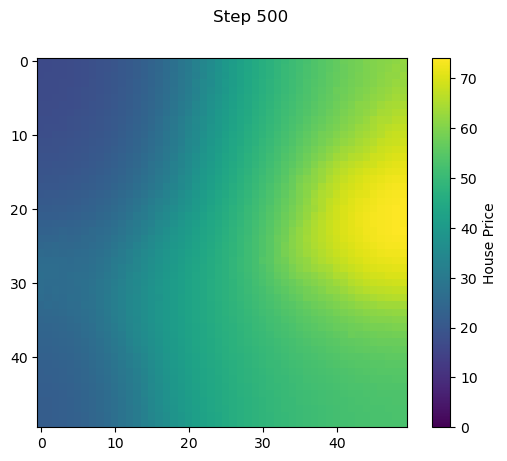

In [61]:
np.random.seed(1234)

# Simulation parameters
n_steps = 500
affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p, rho)

# Set up the plot
fig, ax = plt.subplots()
fig.suptitle('Step 0')

# Set initial color scale to max house price
max_house_price = np.max(house_grid)
img = plt.imshow(house_grid, cmap='viridis', vmin=0, vmax=max_house_price)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label('House Price')

rich_indices = affluence_grid == 1.0
poor_indices = affluence_grid == 0.1

rich_house_prices = house_grid[rich_indices]
poor_house_prices = house_grid[poor_indices]

avg_prices = [house_grid.mean()]
avg_rich_prices = [rich_house_prices.mean()]
avg_poor_prices = [poor_house_prices.mean()]

# Simulation loop
for step in range(n_steps+1):
    # Update house values
    house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)

    # Propose random move - several in each step
    i = 0
    while i < 25:
        i += propose_swap(affluence_grid, house_grid, religion_grid, politics_grid, r, kernel)

    # Calculate new maximum house price for the color scale
    max_house_price = np.max(house_grid)

    rich_indices = affluence_grid == 1.0
    poor_indices = affluence_grid == 0.1
    
    rich_house_prices = house_grid[rich_indices]
    poor_house_prices = house_grid[poor_indices]

    avg_prices.append(house_grid.mean())
    avg_rich_prices.append(rich_house_prices.mean())
    avg_poor_prices.append(poor_house_prices.mean())
    
    # Update image and color scale dynamically
    img.set_array(house_grid)
    img.set_clim(0, max_house_price)  # Update the color scale based on max house price
    fig.suptitle(f"Step {step}")
    
    if step % 20 == 0:
        plt.pause(0.1)
        clear_output(wait=True)
        display(fig)

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Affluence')
img = plt.imshow(affluence_grid, cmap='viridis')

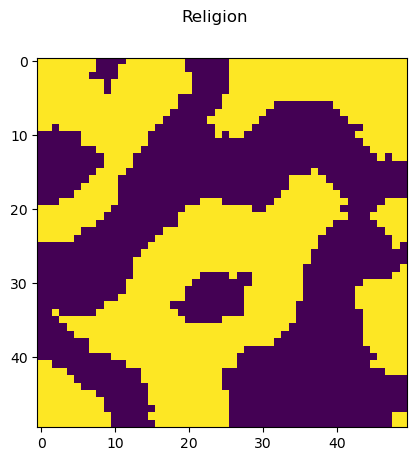

In [170]:
fig, ax = plt.subplots()
fig.suptitle('Religion')
img = plt.imshow(religion_grid, cmap='viridis')

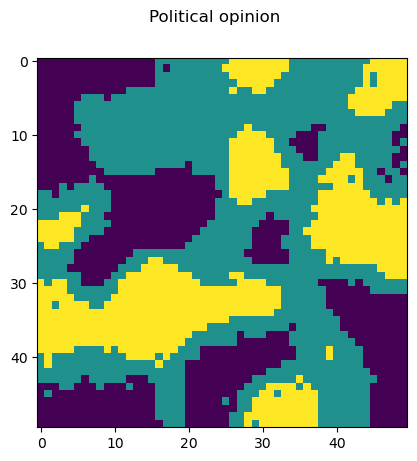

In [171]:
fig, ax = plt.subplots()
fig.suptitle('Political opinion')
img = plt.imshow(politics_grid, cmap='viridis')

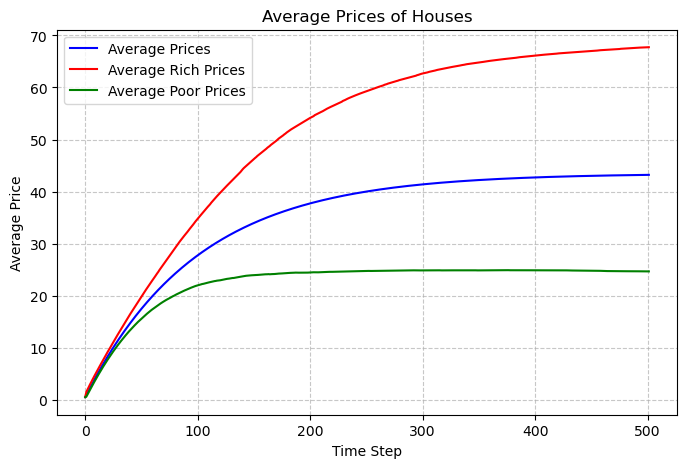

In [62]:
# Create indices for the averages
indices = list(range(len(avg_prices)))

# Plot the averages against their indices
plt.figure(figsize=(8, 5))
plt.plot(indices, avg_prices, linestyle='-', color='b', label="Average Prices")
plt.plot(indices, avg_rich_prices, linestyle='-', color='r', label="Average Rich Prices")
plt.plot(indices, avg_poor_prices, linestyle='-', color='g', label="Average Poor Prices")
plt.title("Average Prices of Houses")
plt.xlabel("Time Step")
plt.ylabel("Average Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Segregation Index

In [25]:
def spatial_segregation(U):
    m, n = U.shape
    assert m == n, "U (the matrix, not you) must be square" # We could maybe generalise to m != n? But then we'd have to compute our own expected_entropy.

    # Get eigenvals of covariance matrix and apply a normalisation
    Q = U.T @ U # we assume U is real so just use the regular transpose
    eigenvals, _ = np.linalg.eig(Q)
    # keep only real parts (evals should be real but sometimes np accidentally gives a tiny imaginary component).
    # sort eigenvals from largest abs value to smallest, then keep only those that are non zero
    eigenvals = np.array(sorted(np.real(eigenvals), key = abs, reverse = True))
    eigenvals = eigenvals[np.abs(eigenvals) > 1e-5] # get rid of eigenvalues that are basically 0
    p_i_denom = sum(np.abs(eigenvals[1:]))
    p = eigenvals / p_i_denom

    # Measure the entropy and subtract from the expected entropy to get the segregation measure
    H_BO = -sum(p[1:] * np.log(p[1:]))
    expected_entropy = np.log(3/5 * n) # this is given in the text. Although they don't specify natural log, this is closest to actual results
    S_BO = expected_entropy - H_BO

    return S_BO

def theil_index(props):
    """Get the theil index (a measure of inequality) of a vector of n proportions

    Args:
        props (np.ndarray): Proportions (must sum to around 1)

    Returns:
        float: Theil index of given distribution
    """
    assert all(props >= 0), "Proportions should all be non-negative"
    assert np.abs(np.sum(props) - 1) < 1e-5, "Proportions should sum to 1 (modulo some rounding errors)"
    return np.log(len(props)) + np.sum(props * np.log(props))

def generate_unequal_props(eta: float):
    """Generate a vector of 3 proportions using the 1 parameter family 5.1 from Aguilera et al 2007. You can
    then multiply these proportions by your total number of agents to get the desired number of agents in each group.

    Args:
        eta (float): A parameter between 0.5 and 1 (exclusive), used to generate the proportions. A higher eta corresponds to a higher Theil index.

    Returns:
        props: A 3d vector of proportions, proportion poor, middle, and rich (in that order).
        ti: The Theil index corresponding to the above vector
    """
    assert 0.5 < eta < 1, "Eta must be between 0.5 and 1 (exclusive)"

    a = 0.4 # this is the fixed value used throughout section 5 of Aguilera
    props = np.array([eta, (1-a)*(1-eta), a*(1-eta)])
    ti = theil_index(props)

    return props, ti

#### Segregation over time

In [99]:
# Simulation parameters
n_steps = 200
affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p, rho)
seg_indices=[]

# Simulation loop
for step in range(n_steps+1):
    # Update house values
    house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)
    
    # Propose random move - several in each step
    i = 0
    while i < 25:
        i += propose_swap(affluence_grid, house_grid, religion_grid, politics_grid, r, kernel)
        
    seg_ind = spatial_segregation(house_grid)
    seg_indices.append(seg_ind)

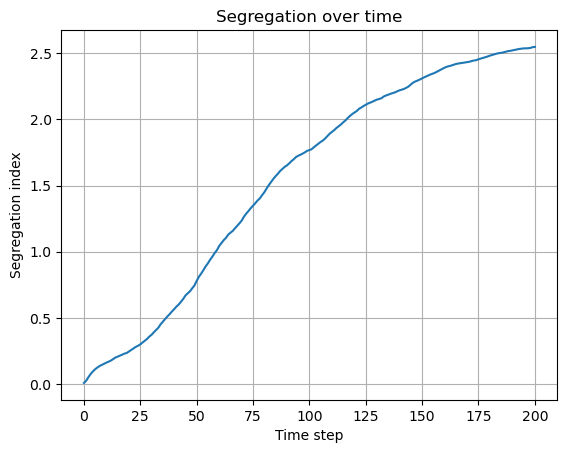

In [100]:
indices = list(range(len(seg_indices)))
plt.plot(indices, seg_indices)
plt.xlabel('Time step')
plt.ylabel('Segregation index')
plt.title('Segregation over time')
plt.grid(True)
plt.show()

#### Segregation over time + error bars (std)

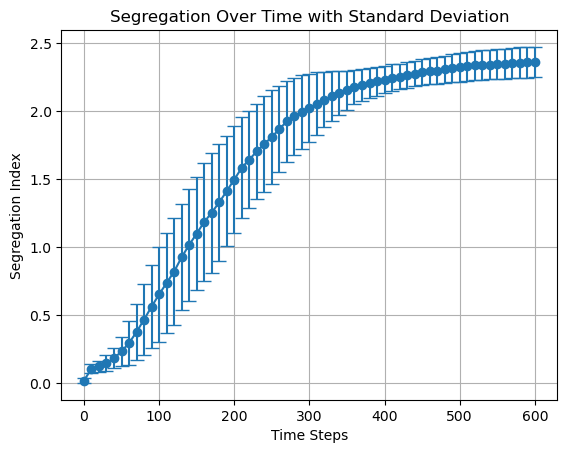

In [27]:
# Simulation parameters
n_steps = 600
step_interval = 10  # Record segregation index every 100 steps
n_time_points = n_steps // step_interval + 1
n_experiments = 5

seg_indices = np.zeros((n_experiments, n_time_points))

for j in range(n_experiments):
    # Initialize random board
    affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p, rho)
    
    # Simulation loop
    for step in range(n_steps + 1):
        # Update house values
        house_grid = calculate_new_house_values_conv(affluence_grid, house_grid, r, lambda_)
        
        # Propose random swaps
        i = 0
        while i < 25:
            i += propose_swap(affluence_grid, house_grid, religion_grid, politics_grid, r, kernel)
        
        # Record segregation index every 100 steps
        if step % step_interval == 0:
            seg_ind = spatial_segregation(house_grid)
            seg_indices[j][step // step_interval] = seg_ind

# Calculate mean and standard deviation of segregation indices
mean_seg = np.mean(seg_indices, axis=0)
std_seg = np.std(seg_indices, axis=0)

# Time points corresponding to recorded steps
time_points = np.arange(0, n_steps + 1, step_interval)

# Plotting with error bars
plt.errorbar(time_points, mean_seg, yerr=std_seg, fmt='-o', capsize=5, label='Segregation Index')
plt.xlabel('Time Steps')
plt.ylabel('Segregation Index')
plt.title('Segregation Over Time with Standard Deviation')
plt.grid(True)
plt.show()

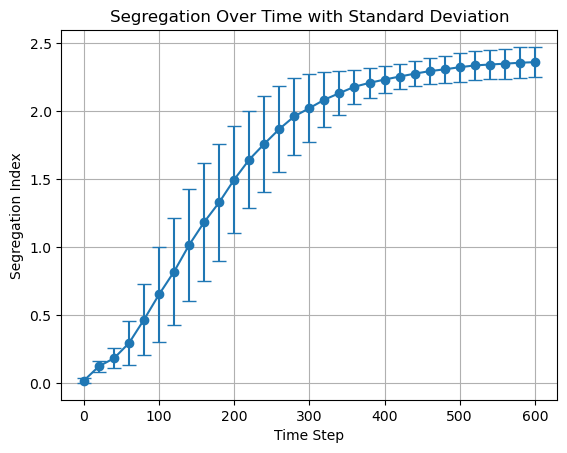

In [33]:
# Time points corresponding to recorded steps
time_points = np.arange(0, n_steps + 1, step_interval)

# Select every second data point
time_points_reduced = time_points[::2]
mean_seg_reduced = mean_seg[::2]
std_seg_reduced = std_seg[::2]

# Plotting with error bars
plt.errorbar(time_points_reduced, mean_seg_reduced, yerr=std_seg_reduced, fmt='-o', capsize=5, label='Segregation Index')
plt.xlabel('Time Step')
plt.ylabel('Segregation Index')
plt.title('Segregation Over Time with Standard Deviation')
plt.grid(True)
plt.show()